Projet : Dubai Mall - Segmentation de la clientèle

Ce projet a pour objectif de segmenter la clientèle du Dubai Mall à l’aide de techniques de clustering (apprentissage non supervisé) afin de mieux comprendre les comportements d’achat et de proposer des stratégies marketing ciblées.

Le jeu de données utilisé contient des informations démographiques et comportementales sur les clients, notamment :

le sexe, l’âge, le revenu annuel, le score de dépense.
Ces variables permettent de capturer :
- La dimension démographique
- La capacité financière
- Le comportement d’achat


Inspection initiale

In [2]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (
shapiro, normaltest,
spearmanr, pearsonr,
mannwhitneyu, ttest_ind,
chi2_contingency, skew, kurtosis
)
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [3]:
#Importation de notre jeu de donnée et apercu des 5 premières lignes
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
#Dimmension du jeu de donnée
df.shape

(200, 5)

In [5]:
#Détection de doublon
print("Doublons :", df.duplicated().sum())

Doublons : 0


In [6]:
#Structure et types des variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
#Recherche de valeurs manquantes ecrites comme comme du texte "NaN"
(df == "NaN").sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
# Affichage des modalités de chaque variable catégorielle afin de détecter la presence d'autre présence de valeur manque 
for col in df.select_dtypes(include=['object', 'bool']).columns:
    print(col, ":", df[col].unique())
    print("\n")

Gender : ['Male' 'Female']




Commentaire : Le jeu de donnée contient 200 observations et 5 variables. Parmis les variables étudiées, nous avons 4 variables de types numériques (int64) et une variables de types catégorielles (objet). Nous observons une absence de valeurs manquantes au niveaux des variables. Pas de doublon observé. Juste la variable "CustomerID" devra etre suprimée car elle n'apporte aucune valeurs statistiques à notre études. Il s'agit d'une numérotation servant d'ID affecter aux observations. 

In [9]:
#Suppression de la variable (Custumer ID)
df = df.drop(columns="CustomerID")

Statistique descriptive

In [10]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


Commentaire : 
    -Age : L'age moyen est d'environ 39 ans et la mediane est de 36 ans, ce qui indique une légère asymetrie à droite. Les âges s’étendent de 18 à 70 ans, montrant une population assez variée. Cette diversité est intéressante pour envisager une segmentation pertinente des clients. 
    -Revenu annuel : Le revenu annuel moyen est d’environ 60,6 k$, avec une médiane à 61,5 k$, ce qui indique une distribution relativement symétrique. Les revenus s’étendent de 15 k$ à 137 k$, traduisant une forte hétérogénéité au sein de la population. Cette dispersion des revenus constitue un élément clé pour la segmentation, car elle permet de distinguer des profils de clients à pouvoir d’achat différent.
    -Spending Score : Le Spending Score moyen est d’environ 50, avec une médiane également proche de 50, indiquant une distribution globalement symétrique. Les valeurs s’étendent de 1 à 99, ce qui révèle une forte variabilité des comportements d’achat. Cette diversité est particulièrement pertinente pour la segmentation, car elle permet d’identifier des clients à faible, moyen ou fort niveau de dépenses, indépendamment de leur revenu.

    Implication pour la segmentation: Ces différences marquées entre les clients constituent une base solide pour la segmentation, permettant d’identifier des profils distincts et d’adapter les stratégies marketing en conséquence.

Numeriques

ANALYSE UNIVARIE

In [11]:
#Catégorisation des variables de la dataset
num_vars = df.select_dtypes(include=np.number).columns
cat_vars = df.select_dtypes(include='object').columns
num_vars, cat_vars

(Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object'),
 Index(['Gender'], dtype='object'))

VARIABLE NUMÉRIQUE : Age

Statistiques descriptives :
count    200.000000
mean      38.850000
std       13.969007
min       18.000000
25%       28.750000
50%       36.000000
75%       49.000000
max       70.000000
Name: Age, dtype: float64




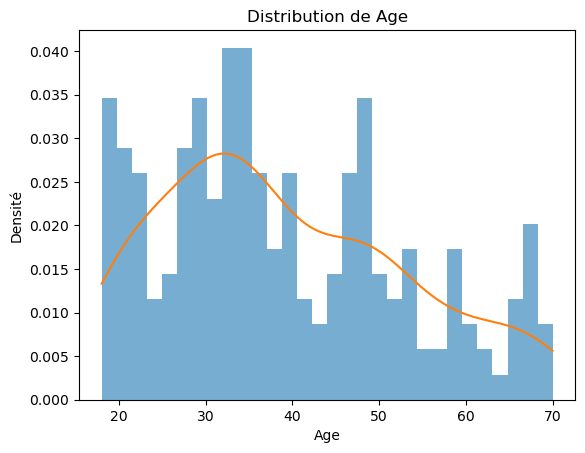

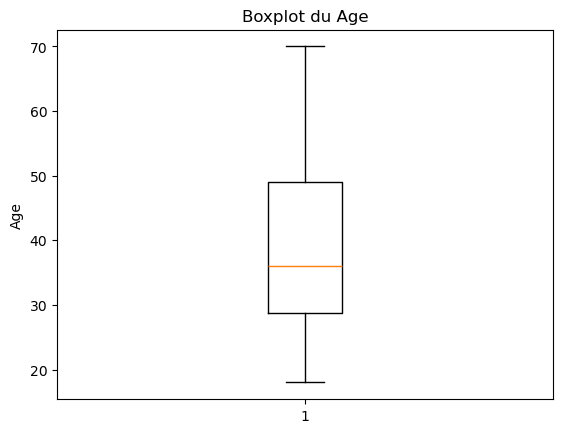


Skewness : 0.482
Kurtosis : -0.685

Test de normalité (shapiro) : p-value = 0.0000

Conclusion : Distribution NON normale → tests NON paramétriques
VARIABLE NUMÉRIQUE : Annual Income (k$)

Statistiques descriptives :
count    200.000000
mean      60.560000
std       26.264721
min       15.000000
25%       41.500000
50%       61.500000
75%       78.000000
max      137.000000
Name: Annual Income (k$), dtype: float64




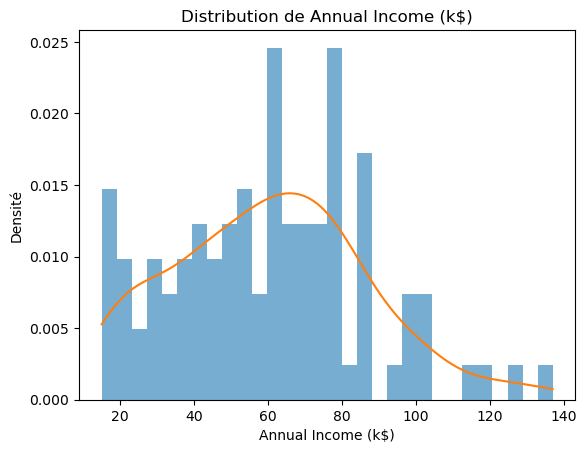

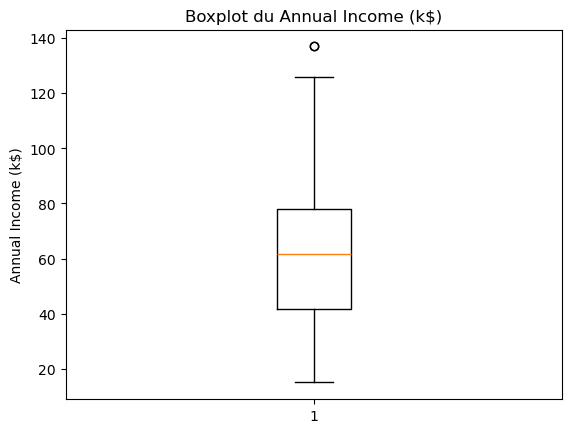


Skewness : 0.319
Kurtosis : -0.126

Test de normalité (shapiro) : p-value = 0.0035

Conclusion : Distribution NON normale → tests NON paramétriques
VARIABLE NUMÉRIQUE : Spending Score (1-100)

Statistiques descriptives :
count    200.000000
mean      50.200000
std       25.823522
min        1.000000
25%       34.750000
50%       50.000000
75%       73.000000
max       99.000000
Name: Spending Score (1-100), dtype: float64




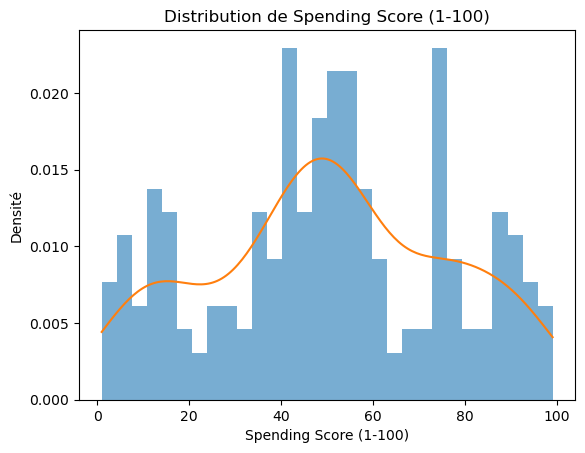

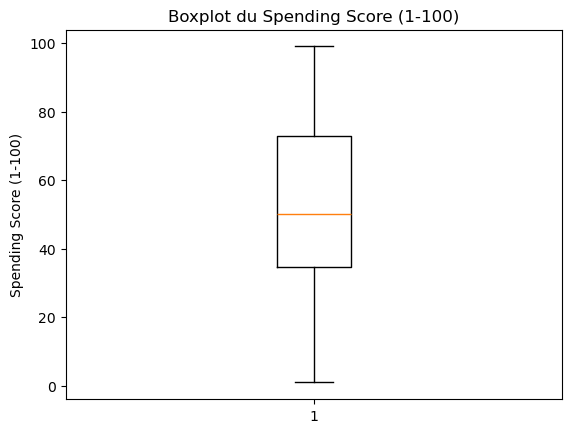


Skewness : -0.047
Kurtosis : -0.836

Test de normalité (shapiro) : p-value = 0.0002

Conclusion : Distribution NON normale → tests NON paramétriques


In [12]:
#Exploration rapide des variables numériques
for var in num_vars:
    print("="*60)
    print(f"VARIABLE NUMÉRIQUE : {var}")


    # Statistiques descriptives
    print("\nStatistiques descriptives :")
    print(df[var].describe())
    print("\n")

    # Histogramme normalisé
    plt.hist(df[var], bins=30, density=True, alpha=0.6)

    # Courbe de densité
    density = gaussian_kde(df[var])
    x = np.linspace(df[var].min(), df[var].max(), 200)
    plt.plot(x, density(x))

    plt.xlabel(var)
    plt.ylabel("Densité")
    plt.title(f"Distribution de {var}")
    plt.show()

    # boxplot
    plt.boxplot(df[var])
    plt.ylabel(var)
    plt.title(f"Boxplot du {var}")
    plt.show()

    # Skewness & Kurtosis
    s = skew(df[var])
    k = kurtosis(df[var])
    print(f"\nSkewness : {s:.3f}")
    print(f"Kurtosis : {k:.3f}")

    # Test de normalité
    #stat, p = normaltest(df[var])
    stat, p = shapiro(df[var])
    print(f"\nTest de normalité (shapiro) : p-value = {p:.4f}")

    # Décision automatique
    if abs(s) > 1 or k > 1 or p < 0.05:
        decision = "Distribution NON normale → tests NON paramétriques"
    else:
        decision = "Distribution quasi normale → tests paramétriques possible"
    print(f"\nConclusion : {decision}")

Commentaire : 
    -Age : Distribution étendue de 18 à 70 ans, Concentration principale entre 20 et 50 ans. Quelques clients plus âgés, mais minoritaires
Possibilité de segments : jeunes acheteurs impulsifs et clients matures plus rationnels
     -Revenu annuel (Annual Income (k$)) : Forte dispersion (15k$ → 137k$). Distribution assez homogène. Pas de concentration excessive sur une tranche. Variable structurante pour identifier : clients sensible au prix et clients sensibles au prix
     - Score de dépense (Spending Score (1-100)): Répartition quasi uniforme entre 1 et 100, Très bonne variable comportementale. Deux clients avec le même revenu peuvent avoir des comportements totalement opposés. C’est LA variable centrale du clustering
     Le test de Shapiro a révélé une distribution non normale: test non parametrique. 

CATEGORIELLE

VARIABLE CATÉGORIELLE : Gender
        Effectif  Pourcentage (%)
Gender                           
Female       112             56.0
Male          88             44.0


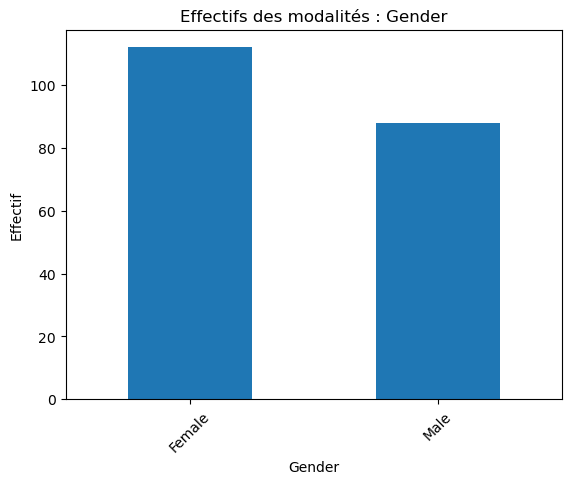

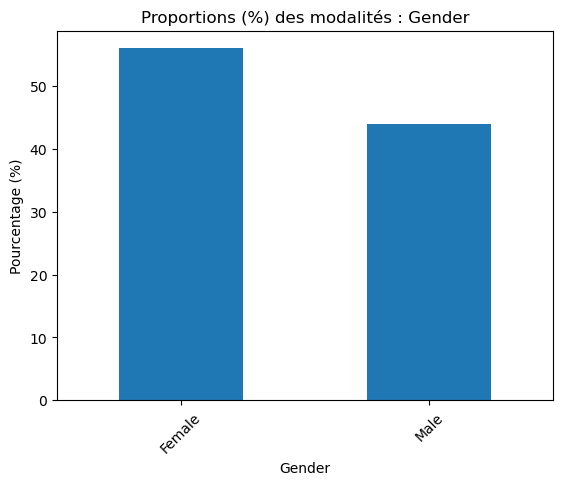

Implication : réflexion nécessaire sur l’encodage, les biais et la robustesse du modèle


In [13]:
for var in cat_vars:
    print("="*70)
    print(f"VARIABLE CATÉGORIELLE : {var}")
    # --------------------
    # 1 Fréquences
    # --------------------
    counts = df[var].value_counts(dropna=False)
    proportions = df[var].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({
    'Effectif': counts,
    'Pourcentage (%)': proportions.round(2)
    })
    print(summary)
    # --------------------
    # 2 Visualisation — effectifs
    # --------------------
    counts.plot(kind='bar')
    plt.title(f"Effectifs des modalités : {var}")
    plt.ylabel("Effectif")
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.show()
    # --------------------
    # 3 Visualisation — proportions
    # --------------------
    proportions.plot(kind='bar')
    plt.title(f"Proportions (%) des modalités : {var}")
    plt.ylabel("Pourcentage (%)")
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.show()
    # --------------------
    # 4 Détection de déséquilibres
    # --------------------
    if proportions.max() > 80:
        print("\n Forte dominance d’une modalité (> 80%)")
    if (proportions < 5).any():
        print(" Modalités rares détectées (< 5%)")
    # --------------------
    # 5 Implication ML
    # --------------------
    print("Implication : réflexion nécessaire sur l’encodage, les biais et la robustesse du modèle")

Commentaire: 
Sexe (Gender) : Deux modalités : Male / Female. Répartition globalement équilibrée. Pas de biais fort. La variable est exploitable sans risque.
Interprétation 
Les comportements d’achat peuvent différer selon le sexe ce qui est pertinent pour une segmentation marketing.

ANALYSE BIVARIEE

ANALYSE BIVARIÉE : AGE ↔ SPENDING SCORE (1-100)


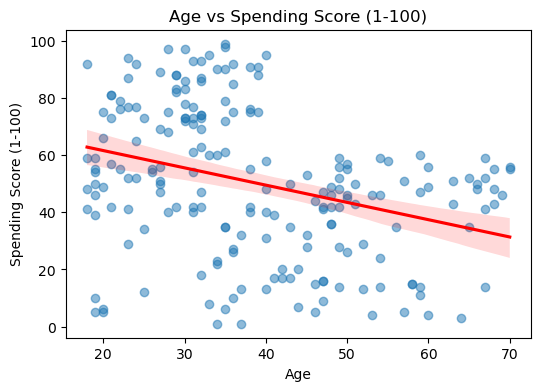

Corrélation de Spearman :
 → p-value = 0.00000
 → corr = -0.3449
 Association statistiquement SIGNIFICATIVE
Relation Négligeable
Rappel : corrélation ≠ causalité

ANALYSE BIVARIÉE : ANNUAL INCOME (K$) ↔ SPENDING SCORE (1-100)


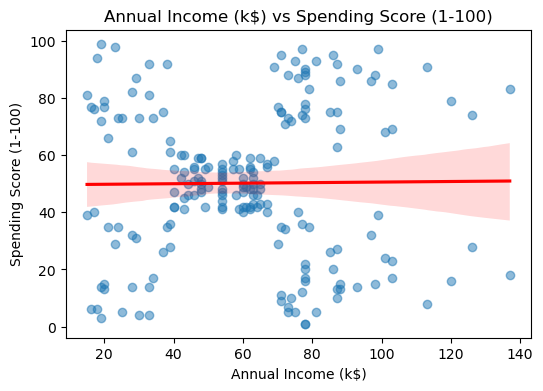

Corrélation de Spearman :
 → p-value = 0.91227
 → corr = 0.0078
 Aucune association statistiquement significative
Relation Négligeable
Rappel : corrélation ≠ causalité



In [14]:
#Prenons la variable "Spending Score (1-100)" comme centrale du clustering
num_vars1 = [v for v in num_vars if v != "Spending Score (1-100)"]
for var in num_vars1:
    print("="*80)
    print(f"ANALYSE BIVARIÉE : {var.upper()} ↔ {"Spending Score (1-100)".upper()}")
    
    x = df[var]
    y = df["Spending Score (1-100)"]


    data = df[[var, "Spending Score (1-100)"]].dropna()
    x = data[var]
    y = data["Spending Score (1-100)"]
    # --------------------
    # 1 VISUALISATION
    # --------------------
    plt.figure(figsize=(6,4))
    sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

    plt.title(f"{var} vs Spending Score (1-100)")
    plt.xlabel(var)
    plt.ylabel("Spending Score (1-100)")
    plt.show()
    # --------------------
    # 2 TEST STATISTIQUE ET TAILLE D'EFFET
    # --------------------
    corr, p_value = spearmanr(x, y)
    print("Corrélation de Spearman :")
    print(f" → p-value = {p_value:.5f}")
    print(f" → corr = {corr:.4f}")
    
    # --------------------
    # 3 INTERPRÉTATION AUTOMATIQUE
    # --------------------
    if p_value < 0.05:
        print(" Association statistiquement SIGNIFICATIVE")
    else:
        print(" Aucune association statistiquement significative")
    # --------------------
    # 4 INTERPRÉTATION MÉTIER (GUIDÉE)
    # --------------------
    if corr > 0.5:
        print("Relation positive forte")
    elif corr >= 0.3 and corr <= 0.5 :
        print("Relation positive Modérée")
    elif corr >= 0.1 and corr < 0.3 :
        print("Relation positive faible")
    elif corr < 0.1:
        print("Relation Négligeable")
    

    print("Rappel : corrélation ≠ causalité\n")

Commentaire : 
    - Âge vs Spending Score : Les clients plus jeunes ont tendance à des scores de dépense plus élevés. Les clients plus âgés montrent un comportement plus modéré
Implication : Marketing différencié selon l’âge. 
    - Revenu annuel vs Spending Score: Graphique fondamental du projet. On observe visuellement : des groupes naturels bien séparés des profils typiques :
Haut revenu / forte dépense : clients VIP
Haut revenu / faible dépense : potentiel à activer
Faible revenu / forte dépense : acheteurs impulsifs
Faible revenu / faible dépense : faible valeur

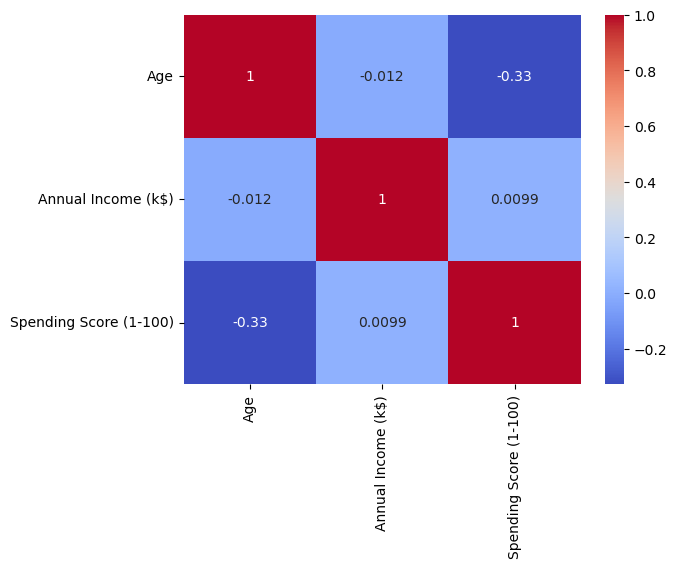

In [15]:
# Matrice de corrélation
corr_matrix = df[num_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Commentaire :  
Corrélation faible entre revenu et spending score : confirme que le comportement d’achat ne dépend pas uniquement du revenu. L'Âge légèrement corrélé négativement au spending score.
Conclusion : Toutes les variables apportent une information complémentaire. Aucune redondance forte donc pas de variable à éliminer

CATÉGORIELLES ↔ Spending Score (1-100)

Test statistique et test d'effet

In [16]:
def cliffs_delta(x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    n_x = len(x)
    n_y = len(y)

    gt = sum(xi > yj for xi in x for yj in y)
    lt = sum(xi < yj for xi in x for yj in y)

    return (gt - lt) / (n_x * n_y)

ANALYSE BIVARIÉE : Gender ↔ SPENDING SCORE (1-100)


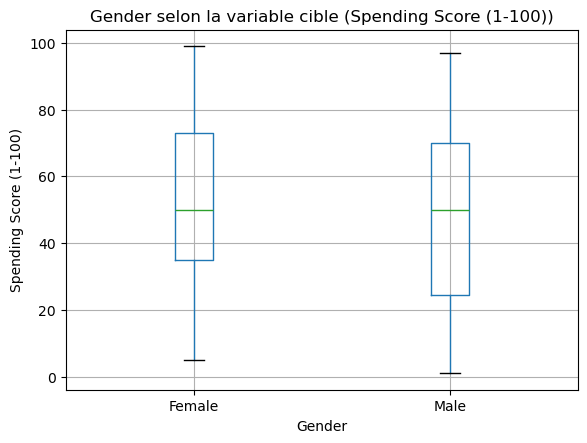

Mann-Whitney U : p-value = 0.57128
Cliff's delta V : -0.047
 Aucune association statistiquement significative détectée
Taille d’effet : négligeable
Interprétation : prudence, pas de causalité


In [17]:
for var in cat_vars:
    print("="*70)
    print(f"ANALYSE BIVARIÉE : {var} ↔ {"Spending Score (1-100)".upper()}")
    
    # Séparation des groupes
    modalites = df[var].unique()
    g1 = df[df[var] == modalites[0]]["Spending Score (1-100)"]
    g2 = df[df[var] == modalites[1]]["Spending Score (1-100)"]


    #  VISUALISATION
    # --------------------
    df.boxplot(column="Spending Score (1-100)", by=var)
    plt.title(f"{var} selon la variable cible (Spending Score (1-100))")
    plt.suptitle("")
    plt.xlabel(var)
    plt.ylabel("Spending Score (1-100)")
    plt.show()

    # Test de Mann-Whitney U
    stat, p = mannwhitneyu(g1, g2, alternative="two-sided")
    print(f"Mann-Whitney U : p-value = {p:.5f}")

    #Test de Cliff's delta
    v = cliffs_delta(g1, g2)
    print(f"Cliff's delta V : {v:.3f}")

    # Vérification des effectifs attendus
    #if (expected < 5).any():
        #print(" Attention : effectifs attendus faibles (test fragile)")
    # Interprétation automatique
    if p < 0.05:
        print(" Association statistiquement significative détectée")
    else:
        print(" Aucune association statistiquement significative détectée")

    # Lecture automatique
    if v < 0.147:
        eff = "négligeable"
    elif v < 0.33:
        eff = "faible"
    elif v < 0.474:
        eff = "modéré"
    else:
        eff = "fort"
    print(f"Taille d’effet : {eff}")

    print("Interprétation : prudence, pas de causalité")


Commentaire : 
Sexe vs comportements d’achat : Différences visibles dans certaines tranches de revenu/dépense. Justifie totalement l’intégration du sexe dans la segmentation.
Le sexe n’est pas une variable de clustering principale, mais une variable explicative des segments.

Conclusion : L’analyse exploratoire met en évidence une forte hétérogénéité des profils clients du Dubai Mall.
Les variables âge, sexe, revenu annuel et score de dépense fournissent des informations complémentaires, justifiant leur utilisation conjointe pour la segmentation. Les visualisations révèlent des regroupements naturels, confirmant la pertinence des méthodes de clustering.